<a href="https://colab.research.google.com/github/Nademm-khans/Plant-Village-using-CNN/blob/main/Final_coding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from glob import glob
import matplotlib.pyplot as plt

Loaded 50 images and 50 masks.


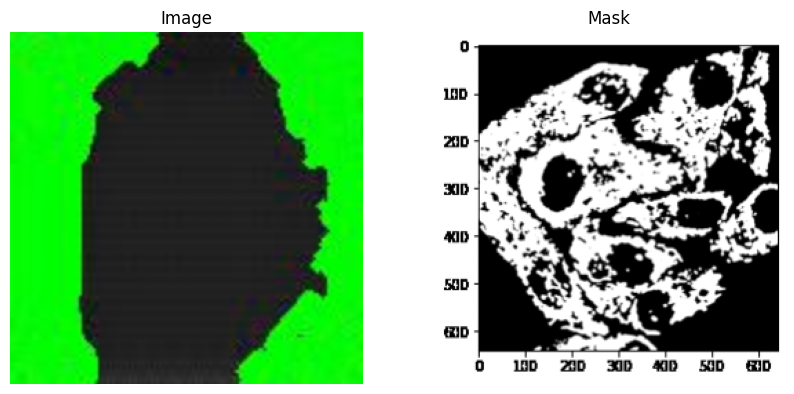

In [19]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

# Load and preprocess the images and masks
def load_data(image_dir, mask_dir, image_size=(256, 256)):
    # Get all image and mask paths
    images = sorted(glob(os.path.join(image_dir, "*.jpg")))  # Adjust extension as per your dataset
    masks = sorted(glob(os.path.join(mask_dir, "*.png")))    # Adjust extension as per your dataset

    X = []
    Y = []

    # Ensure the number of images and masks match
    if len(images) != len(masks):
        print("Warning: The number of images and masks do not match.")

    for img_path, mask_path in zip(images, masks):
        # Load and preprocess image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:  # Check if the image is loaded correctly
            img = cv2.resize(img, image_size)
            img = img / 255.0  # Normalize image
            X.append(img)
        else:
            print(f"Error loading image: {img_path}")

        # Load and preprocess mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is not None:  # Check if the mask is loaded correctly
            mask = cv2.resize(mask, image_size)
            mask = mask / 255.0  # Normalize mask to [0, 1]
            Y.append(mask.reshape(image_size[0], image_size[1], 1))  # Add channel dimension for mask
        else:
            print(f"Error loading mask: {mask_path}")

    X = np.array(X)
    Y = np.array(Y)

    print(f"Loaded {X.shape[0]} images and {Y.shape[0]} masks.")
    return X, Y

# Define paths to your image and mask directories
image_dir = "/content/drive/MyDrive/Data set/drug/images"
mask_dir = "/content/drive/MyDrive/Data set/drug/masks"

# Load the data
X, Y = load_data(image_dir, mask_dir)

# Display a sample image and its corresponding mask
def display_sample(X, Y, index=0):
    plt.figure(figsize=(10, 5))

    # Display image
    plt.subplot(1, 2, 1)
    plt.imshow(X[index])
    plt.title('Image')
    plt.axis('off')

    # Display mask
    plt.subplot(1, 2, 2)
    plt.imshow(Y[index].reshape(Y.shape[1], Y.shape[2]), cmap='gray')  # Reshape mask for display
    plt.title('Mask')
    plt.axis('off')

    plt.show()

# Display the first sample
if len(X) > 0 and len(Y) > 0:
    display_sample(X, Y, index=0)
else:
    print("No images or masks to display.")


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Build the model
IMG_HEIGHT = 128  # Example height, replace with actual value
IMG_WIDTH = 128   # Example width, replace with actual value
IMG_CHANNELS = 3  # Example channels (3 for RGB images)

def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = layers.Input(input_size)

    # Contracting Path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Expansive Path
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = unet_model()

# Show the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1024)   │              0 │ conv2d_7[0][0],        │
│                      

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
import cv2
import numpy as np
import os
from glob import glob

# Load and preprocess the images and masks
def load_data(image_dir, mask_dir, image_size=(256, 256)):
    # Get all image and mask paths
    images = sorted(glob(os.path.join(image_dir, "*.jpg")))  # Adjust extension as per your dataset
    masks = sorted(glob(os.path.join(mask_dir, "*.png")))    # Adjust extension as per your dataset

    print(f"Found {len(images)} images and {len(masks)} masks.")

    X = []
    Y = []

    # Ensure the number of images and masks match
    if len(images) != len(masks):
        print("Warning: The number of images and masks do not match.")

    for img_path, mask_path in zip(images, masks):
        # Load and preprocess image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:  # Check if the image is loaded correctly
            img = cv2.resize(img, image_size)
            img = img / 255.0  # Normalize image
            X.append(img)
        else:
            print(f"Error loading image: {img_path}")

        # Load and preprocess mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is not None:  # Check if the mask is loaded correctly
            mask = cv2.resize(mask, image_size)
            mask = mask / 255.0  # Normalize mask to [0, 1]
            Y.append(mask.reshape(image_size[0], image_size[1], 1))  # Add channel dimension for mask
        else:
            print(f"Error loading mask: {mask_path}")

    X = np.array(X)
    Y = np.array(Y)

    print(f"Loaded {X.shape[0]} images and {Y.shape[0]} masks.")
    return X, Y

# Check directories
image_dir = "/content/drive/MyDrive/Data set/drug/images"
mask_dir = "/content/drive/MyDrive/Data set/drug/masks"

print("Image Directory Exists:", os.path.exists(image_dir))
print("Mask Directory Exists:", os.path.exists(mask_dir))

# List contents of the directories
print("Images found:", os.listdir(image_dir))
print("Masks found:", os.listdir(mask_dir))

# Load data
X, Y = load_data(image_dir, mask_dir)

# To show the shape of the loaded data
print("Loaded image shape:", X.shape)
print("Loaded mask shape:", Y.shape)


Image Directory Exists: True
Mask Directory Exists: True
Images found: ['2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '17.jpg', '27.jpg', '14.jpg', '24.jpg', '23.jpg', '31.jpg', '32.jpg', '22.jpg', '21.jpg', '20.jpg', '19.jpg', '18.jpg', '15.jpg', '49.jpg', '47.jpg', '46.jpg', '30.jpg', '41.jpg', '13.jpg', '36.jpg', '35.jpg', '29.jpg', '28.jpg', '16.jpg', '26.jpg', '25.jpg', '48.jpg', '45.jpg', '50.jpg', '44.jpg', '43.jpg', '42.jpg', '40.jpg', '39.jpg', '38.jpg', '37.jpg', '34.jpg', '33.jpg', 'prediction_0.jpg', '1.jpg']
Masks found: ['1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '4

In [27]:
# Data preprocessing and train-test split
X, Y = load_data(image_dir, mask_dir)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

Found 51 images and 50 masks.
Loaded 50 images and 50 masks.


In [28]:
# Initialize and train the model
model = unet_model(input_size=(256, 256, 3))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 256)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 512)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_28[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4        

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=8, validation_data=(X_val, Y_val))

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 351s 56s/step - accuracy: 0.4602 - loss: 0.6727 - val_accuracy: 0.4946 - val_loss: 0.6360
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 368s 54s/step - accuracy: 0.4644 - loss: 0.6463 - val_accuracy: 0.4875 - val_loss: 0.6356
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 380s 54s/step - accuracy: 0.4593 - loss: 0.6402 - val_accuracy: 0.4648 - val_loss: 0.6289
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 331s 55s/step - accuracy: 0.4563 - loss: 0.7273 - val_accuracy: 0.4946 - val_loss: 0.6417
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 377s 54s/step - accuracy: 0.4654 - loss: 0.6409 - val_accuracy: 0.4946 - val_loss: 0.6439
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 383s 54s/step - accuracy: 0.4529 - loss: 0.6548 - val_accuracy: 0.4946 - val_loss: 0.6286
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 383s 54s/step - accuracy: 0.4696 - loss: 0.6372 - val_accuracy: 0.4946 - val_loss: 0.6253
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 378s 54s/step - accuracy: 0.4667 - loss: 0.6369 - val_accuracy: 0.4946 - val_loss:

Model is trained: True
X_val shape: (5, 256, 256, 3)
Y_val shape: (5, 256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predictions shape: (5, 256, 256, 1)
Sample predictions: [[[0.56791806]
  [0.618107  ]
  [0.66522664]
  ...
  [0.68075377]
  [0.6472223 ]
  [0.5925802 ]]

 [[0.60006046]
  [0.67468065]
  [0.7419006 ]
  ...
  [0.7655384 ]
  [0.71819216]
  [0.63721013]]

 [[0.620555  ]
  [0.7118979 ]
  [0.7874957 ]
  ...
  [0.81332463]
  [0.7602375 ]
  [0.6651167 ]]

 ...

 [[0.6289653 ]
  [0.7276596 ]
  [0.800009  ]
  ...
  [0.8255869 ]
  [0.7754474 ]
  [0.6807017 ]]

 [[0.62496156]
  [0.7151826 ]
  [0.77951026]
  ...
  [0.79999256]
  [0.75487256]
  [0.665825  ]]

 [[0.58684707]
  [0.6485184 ]
  [0.69575644]
  ...
  [0.7132483 ]
  [0.6815045 ]
  [0.62339467]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


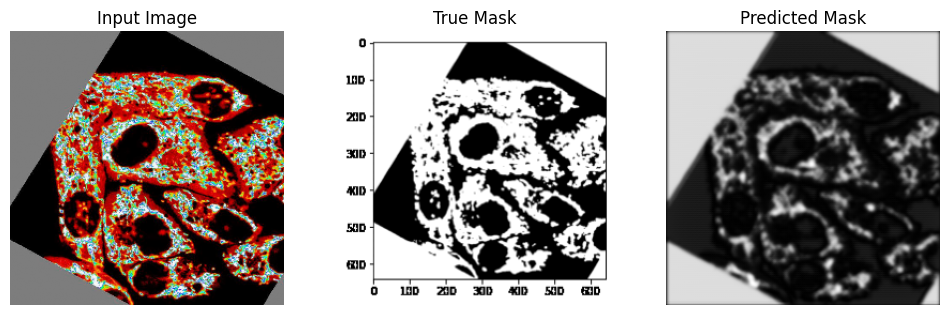

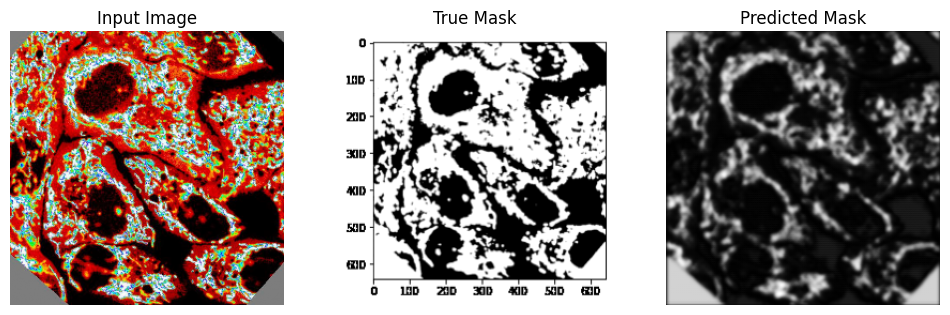

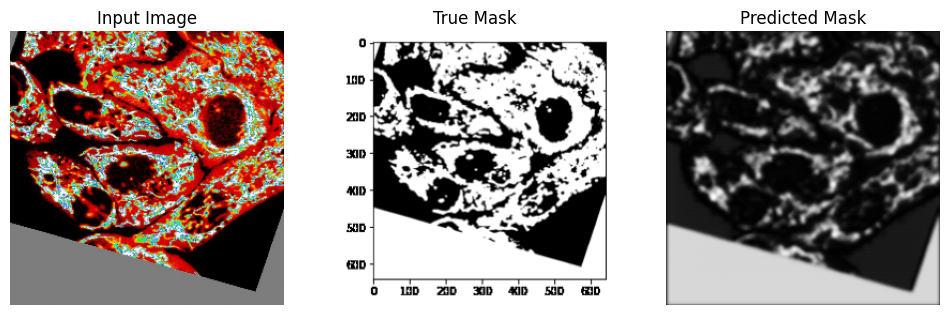

In [34]:
# Check if the model has been trained
print("Model is trained:", model.history is not None)

# Check validation shapes
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)

# Get predictions
preds = model.predict(X_val)
print("Predictions shape:", preds.shape)
print("Sample predictions:", preds[0])  # Show the first prediction

# Function to plot sample predictions
def plot_sample_predictions(model, X_val, Y_val, num_samples=3):
    preds = model.predict(X_val)
    num_samples = min(num_samples, X_val.shape[0])

    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        # Plot Input Image
        plt.subplot(1, 3, 1)
        plt.imshow(X_val[i])
        plt.title("Input Image")
        plt.axis("off")

        # Plot True Mask
        plt.subplot(1, 3, 2)
        plt.imshow(Y_val[i].squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis("off")

        # Plot Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

# Ensure we have data to plot
if X_val.shape[0] > 0 and Y_val.shape[0] > 0 and preds.shape[0] > 0:
    plot_sample_predictions(model, X_val, Y_val, num_samples=3)
else:
    print("Validation data or predictions are missing.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


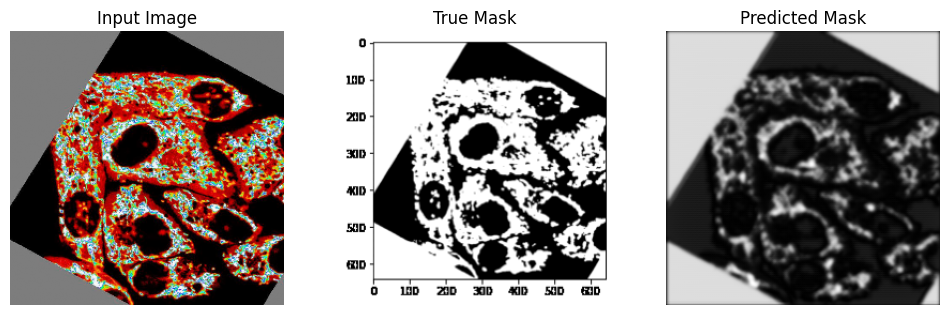

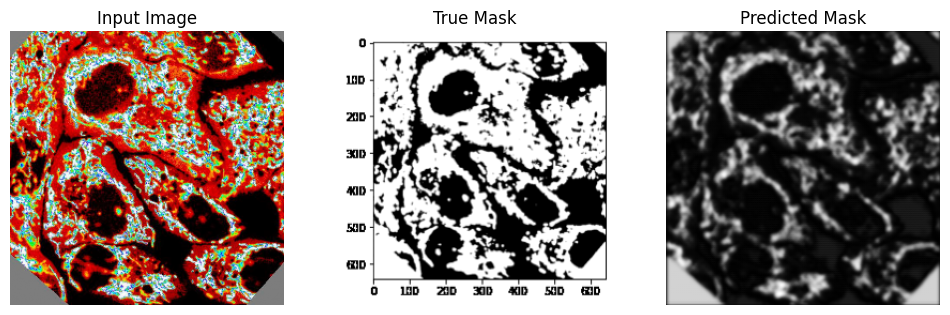

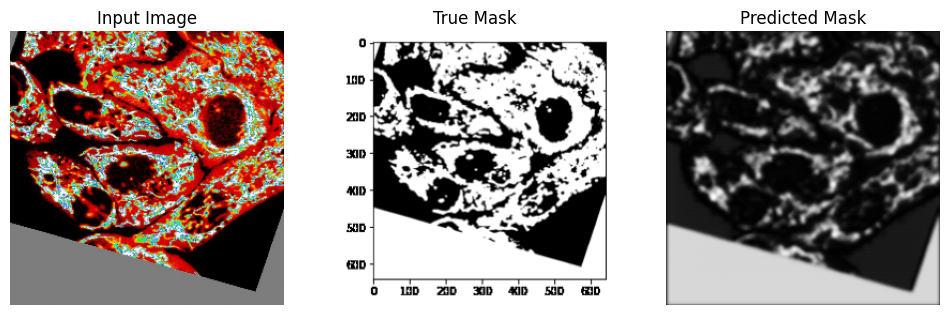

In [35]:
# Show predictions on validation set
plot_sample_predictions(model, X_val, Y_val)

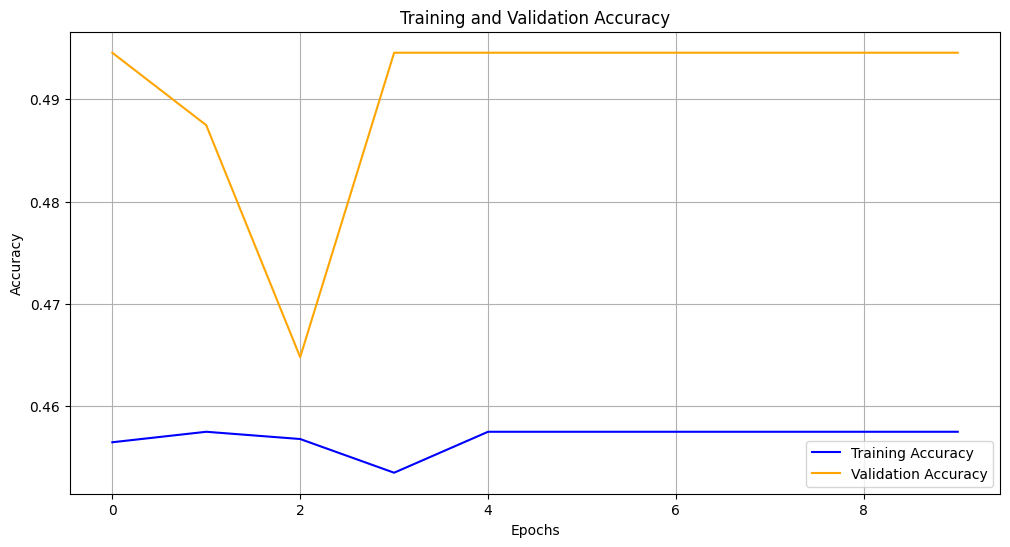

In [37]:
import matplotlib.pyplot as plt

# Retrieve accuracy and validation accuracy from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting the accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


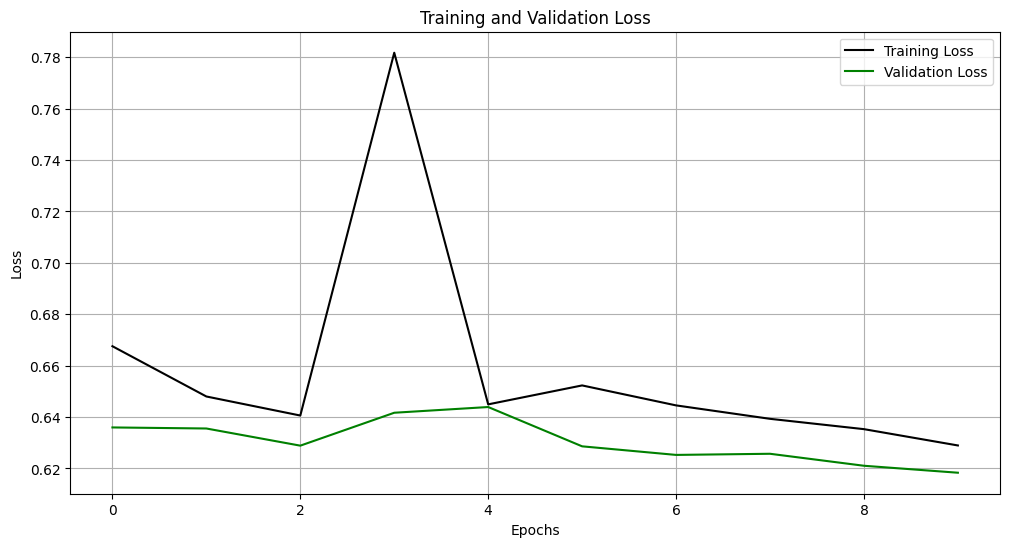

In [38]:
# Retrieve loss and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='Black')
plt.plot(val_loss, label='Validation Loss', color='Green')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
